$\newcommand{\re}{\mathbb{R}}$
# QR factorization
Given $A \in \re^{m \times n}$ with $m \ge n$ and $rank(A)=n$, we want to write it as

$$
A = Q R
$$

where $Q$ has orthonormal columns, $Q^\top Q = I_{n \times n}$ and $R$ is upper triangular matrix.

In [29]:
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt

## Classical Gram-Schmidt algorithm

We now implement the Gram-Schmidt algorithm.

In [30]:
def clgs(A):
    m, n = A.shape
    Q, R = np.empty((m,n)), np.zeros((n,n))
    for j in range(n):
        v = A[:,j]
        for i in range(j):
            R[i,j] = Q[:,i].dot(A[:,j])
            v = v - R[i,j] * Q[:,i]
        R[j,j] = np.linalg.norm(v)
        Q[:,j] = v / R[j,j]
    return Q, R

Generate a random matrix and compute the decomposition

In [31]:
m, n = 10, 5
A = 2 * np.random.rand(m,n) - 1
Q, R = clgs(A)

Test that $A = Q R$ is satisfied, compute $\max_{i,j}| (A - Q R)_{ij} |$

In [32]:
np.abs(A - Q @ R).max()

4.440892098500626e-16

Are the columns of $Q$ orthonormal, i.e., $Q^\top Q = I_{n\times n}$ ?

In [33]:
np.abs(Q.T @ Q - np.eye(n)).max()

2.220446049250313e-16

## Modified Gram-Schmidt

We now implement the modified Gram-Schmidt algorithm.

In [34]:
def mgs(A):
    m, n = A.shape
    V = A.copy()
    Q, R = np.empty((m,n)), np.zeros((n,n))
    for i in range(n):
        R[i,i] = np.linalg.norm(V[:,i])
        Q[:,i] = V[:,i] / R[i,i]
        for j in range(i+1,n):
            R[i,j] = Q[:,i].dot(V[:,j])
            V[:,j] = V[:,j] - R[i,j] * Q[:,i]
    return Q, R

Let us test it following similar approach as above.

In [35]:
Q, R = mgs(A)

Test that $A = Q R$ is satisfied,

In [36]:
np.abs(A - Q @ R).max()

4.440892098500626e-16

Are the columns of $Q$ orthonormal, i.e., $Q^\top Q = I_{n\times n}$ ?

In [37]:
np.abs(Q.T @ Q - np.eye(n)).max()

2.247069251252757e-16

## Comparing the two algorithms

Generate random unitary matrices

In [38]:
U, X = np.linalg.qr(np.random.rand(80,80))
V, X = np.linalg.qr(np.random.rand(80,80))
S = np.diag(2.0**np.arange(-1,-81,-1))
A = U @ S @ V

In [39]:
Qc, Rc = clgs(A)
Qm, Rm = mgs(A)

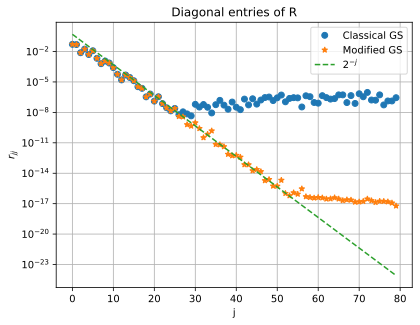

In [40]:
plt.semilogy(np.diag(Rc),'o',label='Classical GS')
plt.semilogy(np.diag(Rm),'*',label='Modified GS')
plt.semilogy(2.0**np.arange(-1,-81,-1),'--',label='$2^{-j}$')
plt.xlabel("j"); plt.ylabel("$r_{jj}$")
plt.title("Diagonal entries of R")
plt.grid(True); plt.legend();

## A $2 \times 2$ example: numerical loss of orthogonality

The `qr` function in `numpy` uses Housholder triangularization. We test it on a matrix whose columns are almost parallel and compare with GS algorithm.

In [41]:
A = np.array([[0.70000, 0.70711],
              [0.70001, 0.70711]])
Q, R = np.linalg.qr(A)
print('Householder QR = ',np.abs(Q.T @ Q - np.eye(2)).max())
Q, R = mgs(A)
print('Modified GS QR = ',np.abs(Q.T @ Q - np.eye(2)).max())

Householder QR =  2.220446049250313e-16
Modified GS QR =  2.301438892308072e-11


The orthonormality of columns of $Q$ is not accurate to machine precision using the modified GS algorithm.

## Householder triangularization

The Householder method returns the full QR factorization. In the Algorithm given in the book, $R$ is computed in place of $A$, but here we make a copy and then modify it, because we want to keep $A$ for verification.

In [42]:
# We need sign function with sign(0) = 1
def sign(x):
    if x >= 0.0:
        return 1.0
    else:
        return -1.0

def house(A):    
    # Algorithm 10.1
    R = A.copy()
    m, n = A.shape
    V = []
    for k in range(n):
        x = R[k:m,k]
        e1 = np.zeros_like(x); e1[0] = 1.0
        v = sign(x[0]) * np.linalg.norm(x) * e1 + x
        v = v / np.linalg.norm(v); V.append(v)
        for j in range(k,n):
            R[k:m,j] = R[k:m,j] - 2.0 * v * np.dot(v, R[k:m,j])
    
    # Algorithm 10.3
    # Compute Q as Q*I
    Q = np.empty((m,m))
    for i in range(m): # Compute i'th column of Q
        x = np.zeros(m)
        x[i] = 1.0
        for k in range(n-1,-1,-1):
            x[k:m] = x[k:m] - 2.0 * np.dot(V[k],x[k:m]) * V[k]
        Q[:,i] = x
        
    return Q, R

Let us test the above method.

In [43]:
m, n = 10, 5
A = 2 * np.random.rand(m,n) - 1
Q, R = house(A)

Check that $A=QR$ is satisfied

In [44]:
np.abs(A - Q @ R).max()

1.1102230246251565e-15

Chect that columns of $Q$ are orthonormal

In [45]:
np.abs(Q.T @ Q - np.eye(m)).max()

8.881784197001252e-16

## A $2 \times 2$ example: numerical loss of orthogonality

We repeat the previous test using our own implementation of Householder.

In [46]:
A = np.array([[0.70000, 0.70711],
              [0.70001, 0.70711]])
Q, R = house(A)
print('Householder QR = ', np.abs(Q.T @ Q - np.eye(2)).max())
Q, R = mgs(A)
print('Modified GS QR = ',np.abs(Q.T @ Q - np.eye(2)).max())

Householder QR =  1.1102230246251565e-16
Modified GS QR =  2.301438892308072e-11
